In [1]:
import pandas as pd
import numpy as np

import keras
from keras import layers
from keras import models
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, image
from keras.applications import mobilenet_v2
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model

import math
from sklearn.metrics import confusion_matrix, classification_report

import glob
import os
from pathlib import Path
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
keras.__version__

'2.5.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = '/content/drive/MyDrive/threeclass/train'
validation_dir = '/content/drive/MyDrive/threeclass/validation'
test_dir = '/content/drive/MyDrive/threeclass/test'

In [5]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [6]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 30
num_of_categories = 3

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_count, num_of_categories)) 
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='categorical')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1799)
validation_features, validation_labels = extract_features(validation_dir, 600)
test_features, test_labels = extract_features(test_dir, 600)

Found 1799 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [8]:
train_features = np.reshape(train_features, (1799, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (600, 4 * 4 * 512))
test_features = np.reshape(test_features, (600, 4 * 4 * 512))

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [10]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=30,
                    validation_data=(validation_features, validation_labels), 
                    validation_steps=20)

Epoch 1/30
60/60 [==============================] - 17s 43ms/step - loss: 1.1281 - acc: 0.4837 - val_loss: 0.9265 - val_acc: 0.5183
Epoch 2/30
60/60 [==============================] - 2s 33ms/step - loss: 0.7724 - acc: 0.6517 - val_loss: 0.7254 - val_acc: 0.6650
Epoch 3/30
60/60 [==============================] - 2s 34ms/step - loss: 0.5499 - acc: 0.7776 - val_loss: 0.6419 - val_acc: 0.7267
Epoch 4/30
60/60 [==============================] - 2s 33ms/step - loss: 0.4646 - acc: 0.8134 - val_loss: 0.6136 - val_acc: 0.7733
Epoch 5/30
60/60 [==============================] - 2s 33ms/step - loss: 0.3815 - acc: 0.8542 - val_loss: 0.6788 - val_acc: 0.7533
Epoch 6/30
60/60 [==============================] - 2s 33ms/step - loss: 0.3208 - acc: 0.8710 - val_loss: 0.6403 - val_acc: 0.7767
Epoch 7/30
60/60 [==============================] - 2s 33ms/step - loss: 0.2463 - acc: 0.9132 - val_loss: 0.7747 - val_acc: 0.7683
Epoch 8/30
60/60 [==============================] - 2s 34ms/step - loss: 0.2037 - 

In [11]:
model.save('threeclass_transfer.h5')

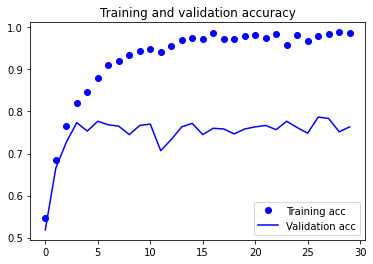

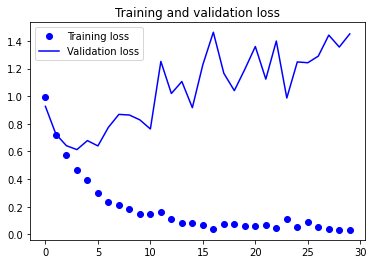

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()